In [2]:
import os
import pandas as pd
import pm4py

Data Loading:

In [4]:
file_dir = '../data/'
file_name = 'Hospital_Billing_Eventlog.xes'
download_url = 'https://data.4tu.nl/file/6af6d5f0-f44c-49be-aac8-8eaa5fe4f6fd/28b83e72-375e-4da4-8459-a8506e898edf'
# Check if file exists and download it if not

# Check if directory exists
if not os.path.exists(file_dir):
    os.system("mkdir " + file_dir)
if not os.path.exists(file_dir + file_name):
    print('Downloading file...')
    os.system(f'wget -O {file_dir + file_name + ".gz"} {download_url}')
    os.system(f'gzip -d {file_dir + file_name + ".gz"}')


In [3]:
data = pm4py.read_xes(file_dir + file_name)
data = pm4py.format_dataframe(data)

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 100000/100000 [00:33<00:00, 2994.51it/s]


In [4]:
# Get overview over data
data

,isCancelled,diagnosis,time:timestamp,caseType,speciality,org:resource,concept:name,blocked,isClosed,flagD,...,closeCode,actRed,actOrange,flagC,msgCount,version,msgType,msgCode,@@index,@@case_index
0,False,A,2012-12-16 19:33:10+00:00,A,A,ResA,NEW,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,NaN,NaN,2013-12-15 19:00:37+00:00,NaN,NaN,NaN,FIN,NaN,NaN,NaN,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,NaN,NaN,2013-12-16 03:53:38+00:00,NaN,NaN,NaN,RELEASE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0
3,NaN,NaN,2013-12-17 12:56:29+00:00,NaN,NaN,NaN,CODE OK,NaN,NaN,NaN,...,NaN,False,False,False,0.0,A,NaN,NaN,3,0
4,NaN,NaN,2013-12-19 03:44:31+00:00,NaN,NaN,ResB,BILLED,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451354,False,UE,2015-06-27 02:01:17+00:00,A,H,ResA,NEW,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,451354,99999
451355,NaN,NaN,2015-07-06 23:57:45+00:00,NaN,NaN,NaN,FIN,NaN,NaN,NaN,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,451355,99999
451356,NaN,NaN,2015-07-15 05:39:38+00:00,NaN,NaN,NaN,RELEASE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,451356,99999
451357,NaN,NaN,2015-07-15 06:33:01+00:00,NaN,NaN,NaN,CODE OK,NaN,NaN,NaN,...,NaN,False,False,False,0.0,E,NaN,NaN,451357,99999


Preprocessing:

In [3]:
# print columns
data = data[['@@case_index', 'diagnosis', 'concept:name', 'isCancelled', 'isClosed']]
data

NameError: name 'data' is not defined

In [6]:
# Save as new, smaller csv
data.to_csv('../data/preprocessed_data.csv', sep=';', index=False)

Feature Extraction:

In [4]:
# Overview over unique values for each column
data = pd.read_csv('../data/preprocessed_data.csv', sep=';')
print("Unique value oveview:\n")
print("======================")
print(data.nunique())
print("======================")
unique_states = data["concept:name"].unique()

Unique value oveview:

@@case_index    100000
diagnosis         1191
concept:name        18
isCancelled          2
isClosed             2
dtype: int64


In [5]:
# Get traces
traces = data.groupby('@@case_index')['concept:name'].apply(tuple).reset_index().rename(columns={"concept:name": "Traces"})

In [6]:
traces

,@@case_index,Traces
0,0,"(NEW, FIN, RELEASE, CODE OK, BILLED)"
1,1,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
2,2,"(NEW,)"
3,3,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
4,4,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
...,...,...
99995,99995,"(NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL..."
99996,99996,"(NEW, DELETE)"
99997,99997,"(NEW, CHANGE DIAGN, DELETE)"
99998,99998,"(NEW,)"


In [7]:
# Get the value counts for each unique trace
trace_counts = traces['Traces'].value_counts()

# Convert to dictionary
trace_counts_dict = trace_counts.to_dict()

In [8]:
trace_counts_dict

{('NEW', 'CHANGE DIAGN', 'FIN', 'RELEASE', 'CODE OK', 'BILLED'): 33672,
 ('NEW',): 22373,
 ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED'): 20901,
 ('NEW', 'DELETE'): 4813,
 ('NEW', 'FIN'): 3508,
 ('NEW',
  'CHANGE DIAGN',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 2121,
 ('NEW', 'CHANGE DIAGN', 'DELETE'): 1555,
 ('NEW', 'FIN', 'RELEASE', 'CODE NOK', 'BILLED'): 977,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 869,
 ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED', 'CODE OK'): 512,
 ('NEW', 'FIN', 'RELEASE', 'CODE NOK', 'EMPTY'): 400,
 ('NEW', 'FIN', 'RELEASE', 'BILLED'): 359,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT',
  'BILLED'): 314,
 ('NEW',
  'FIN',
  'RELEASE',
  'CODE OK',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 273,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT


### Counter Vectorizer 
1. Getting Unique pages and trace_count_dict as dataframe
2. Converting Traces to Strings 
3. Creating CounterVectorizer 
4. Using Vectorizer with traces to create dataframe

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


df = pd.DataFrame(list(trace_counts_dict.items()), columns=['Traces', 'Count'])
traces = [' '.join(trace) for trace in trace_counts_dict.keys()]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(traces) 
df_vectorized = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


### Clustering Algorithm DBSCAN:
1. Clustering of Traces based on vectorized Dataframe with DBSCAN

In [17]:
from sklearn.cluster import DBSCAN


eps = 1.5 
min_samples = 2  

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan.fit(df_vectorized)

df['Cluster'] = dbscan.labels_
df_sorted = df.sort_values(by='Cluster')

df_sorted.to_csv('../data/clustered_traces_countvectorized_dbscan.csv', index=False)

cluster_sizes = df_sorted['Cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} Traces")

Cluster -1: 144 Traces
Cluster 0: 801 Traces
Cluster 1: 2 Traces
Cluster 2: 13 Traces
Cluster 3: 7 Traces
Cluster 4: 2 Traces
Cluster 5: 9 Traces
Cluster 6: 4 Traces
Cluster 7: 2 Traces
Cluster 8: 2 Traces
Cluster 9: 2 Traces
Cluster 10: 3 Traces
Cluster 11: 2 Traces
Cluster 12: 3 Traces
Cluster 13: 2 Traces
Cluster 14: 2 Traces
Cluster 15: 2 Traces
Cluster 16: 2 Traces
Cluster 17: 2 Traces
Cluster 18: 5 Traces
Cluster 19: 2 Traces
Cluster 20: 2 Traces
Cluster 21: 5 Traces
Cluster 22: 2 Traces


### Evaluation:
Silhouette Coefficient: distance between the clusters 

In [18]:
from sklearn.metrics import silhouette_score,silhouette_samples

if len(set(dbscan.labels_)) > 1:  
    silhouette_avg = silhouette_score(df_vectorized, dbscan.labels_)
    print(f"Silhouette Coefficient AVG: {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(df_vectorized, dbscan.labels_)
    for i in range(len(set(dbscan.labels_)) - 1):  
        ith_cluster_silhouette_values = sample_silhouette_values[dbscan.labels_ == i]
        print(f"Silhouette Coefficient for cluster {i}: {np.mean(ith_cluster_silhouette_values)}")
else:
    print("Only one cluster found. No Silhouette Coefficient.")

Silhouette-Koeffizient: -0.2407948441184205
Silhouette-Koeffizient für Cluster 0: -0.23604432980651222
Silhouette-Koeffizient für Cluster 1: 0.6715537281865054
Silhouette-Koeffizient für Cluster 2: 0.4253941776793553
Silhouette-Koeffizient für Cluster 3: 0.09432382000759969
Silhouette-Koeffizient für Cluster 4: 0.552786404500042
Silhouette-Koeffizient für Cluster 5: 0.3346767268080215
Silhouette-Koeffizient für Cluster 6: 0.3745494778420514
Silhouette-Koeffizient für Cluster 7: 0.3577714748119133
Silhouette-Koeffizient für Cluster 8: 0.5179484042051417
Silhouette-Koeffizient für Cluster 9: 0.7479848518836429
Silhouette-Koeffizient für Cluster 10: 0.4458053550474738
Silhouette-Koeffizient für Cluster 11: 0.9555335968379447
Silhouette-Koeffizient für Cluster 12: 0.47345525409939215
Silhouette-Koeffizient für Cluster 13: 1.0
Silhouette-Koeffizient für Cluster 14: 0.6029221980684962
Silhouette-Koeffizient für Cluster 15: 0.7707427929714625
Silhouette-Koeffizient für Cluster 16: 0.539376424

### Visualization:

- Using TSNE to visualize results

/usr/local/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


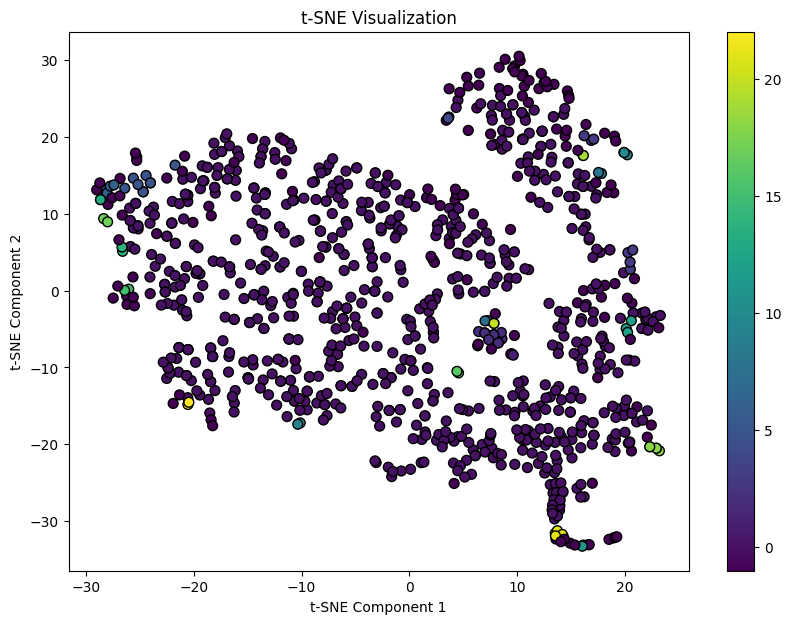

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, perplexity=50, n_iter=1000)
tsne_result = tsne.fit_transform(df_vectorized)
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=dbscan.labels_, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()
